In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

#diplay preferences
%matplotlib inline
pd.options.display.float_format = '{: .3f}'.format

#suppress harmless error
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
data = pd.read_excel('C:/Users/yakan/OneDrive/Documents/Thinkful/DS_Bootcamp/U2/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls',
                     skiprows = 4)

In [3]:
data.head() #we need to predict PRPERTY CRIMES

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan


### Prep data

#### Rename columns, so that the names are easier

In [4]:
data.rename(columns = {data.columns[0]: 'city',
                       data.columns[1]: 'pop',
                       data.columns[2]: 'violent_crime',
                       data.columns[3]: 'murder',
                       data.columns[4]: 'rape_revised',
                       data.columns[5]: 'rape_legacy',
                       data.columns[6]: 'robbery',
                       data.columns[7]: 'assult',
                       data.columns[8]: 'property_crime',
                       data.columns[9]: 'burglary',
                       data.columns[10]: 'theft',
                       data.columns[11]: 'car_theft',
                       data.columns[12]: 'arson'}, inplace = True)

#### Make features (per assignment instructions)

In [5]:
#robbery - change to categorical (everything greater than 0 = 1)
data['robbery_cat'] = data['robbery'].apply(lambda x: 1 if x > 0 else 0)

#https://cmdlinetips.com/2019/05/how-to-create-a-column-using-condition-on-another-column-in-pandas/

In [6]:
data['murder_cat'] = data.iloc[:,3].apply(lambda x: 1 if x > 0 else 0)
#https://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/

In [7]:
data['pop_squared'] = np.square(data['pop'])

#### Feature selection
Here we are going to decide if we want to keep all of the features in the data

Let's see how many crimes occur in each of the cities in the data frame. If there is a city, or a few cities, that have a lot of crime, we could engineer a feature that categorizes "high-crime" cities.

In [8]:
#combine murder and violent crimes into one category 'violence'
data['violence'] = data['violent_crime'] + data['murder']

In [9]:
#calculate the per capita rate of extreme violence
data['violence_rate'] = data['violence'] / data['pop']

See how the predictor varaibles are correlated to each other

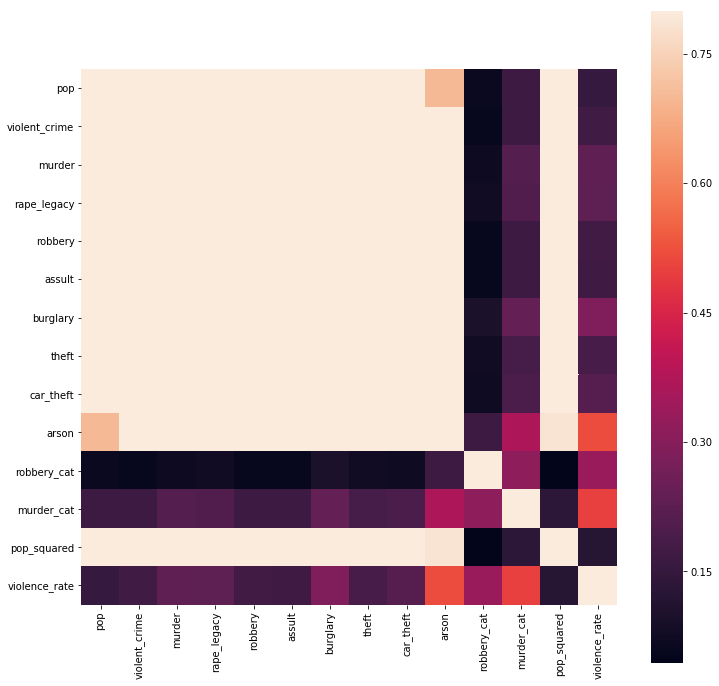

In [10]:
corr_matrix = data[['city', 'pop', 'violent_crime', 'murder', 'rape_legacy',
                    'robbery', 'assult', 'burglary', 'theft', 'car_theft', 'arson',
                    'robbery_cat', 'murder_cat', 'pop_squared', 'violence_rate']].corr()

#set up matplotlib fig
f, ax = plt.subplots(figsize = (12, 12))

#draw heatmap using seaborne
sns.heatmap(corr_matrix, vmax = .8, square = True)
plt.show()

#display(corr_matrix)

The features of this data set are VERY highly correlated to each other! The only features that are not highly correlated are the new features we were directed to design and the one feature ('violence_rate'), which I designed. It makes sense to keep these four features to input into the model and not use the rest of the features, due to the high correlation between them.

#### Examine the relationship between the selected predictors and the outcome variable

I've elected to retain the following predictors for inpur into the model: 'pop_squared', 'murder_cat', 'violence_rate', 'robbery_cat'. Now we need to determine their relationship to the outcome 'property_crime'. We are looking for linearity between the feature and outcome.

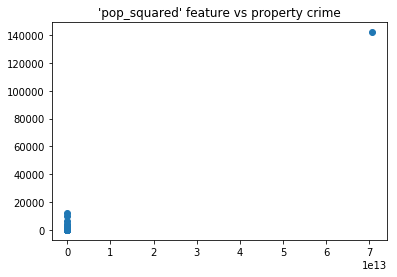

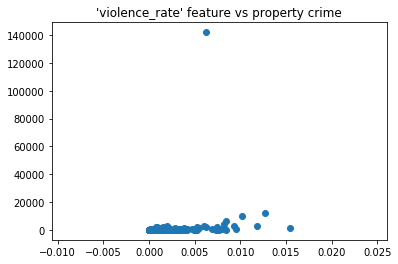

In [11]:
#check to see if features and outcome have a linear relationship
plt.scatter(data['pop_squared'], data['property_crime'])
plt.title("'pop_squared' feature vs property crime")
plt.show()

plt.scatter(data['violence_rate'], data['property_crime'])
plt.title("'violence_rate' feature vs property crime")
plt.show()

c:\users\yakan\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\yakan\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


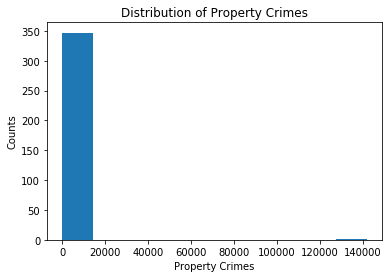

In [12]:
plt.hist(data['property_crime'])
plt.title('Distribution of Property Crimes')
plt.xlabel('Property Crimes')
plt.ylabel('Counts')
plt.show()

There are some serious outliers in property crime variable, let's see what the distributions look like if we leave them out. 

In [13]:
data_subset = data[data['property_crime'] < 120000]

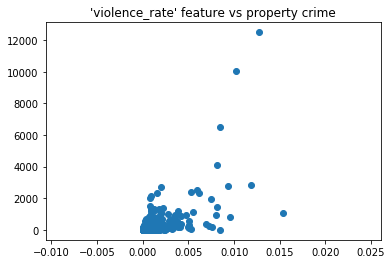

In [14]:
plt.scatter(data_subset['violence_rate'], data_subset['property_crime'])
plt.title("'violence_rate' feature vs property crime")
plt.show()

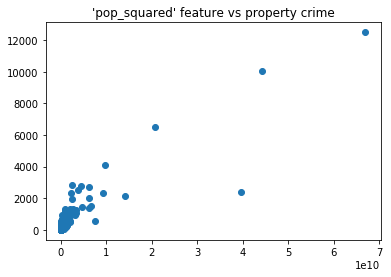

In [15]:
plt.scatter(data_subset['pop_squared'], data_subset['property_crime'])
plt.title("'pop_squared' feature vs property crime")
plt.show()

The relationships between the features and outcome look much more linear after the outliers are left out.

#### Setting up the linear model

In [16]:
regr = linear_model.LinearRegression()
Y = data_subset['property_crime']
X = data_subset[['pop_squared', 'violence_rate', 'robbery_cat', 'murder_cat']]
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [17]:
#inspect results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [1.58096624e-07 9.94201719e+04 1.35144606e+02 1.72684533e+02]

Intercept: 
 -27.220152569869697

R-squared:
0.853870238076001


# Ask how to interpret the outcomes above

#### Check the model's explanatory power

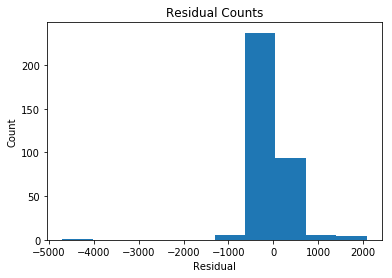

In [27]:
#extract predicted values
predicted = regr.predict(X).ravel()
actual = data_subset['property_crime']

#calculate error (also called residual)
residual = actual - predicted

#graph
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

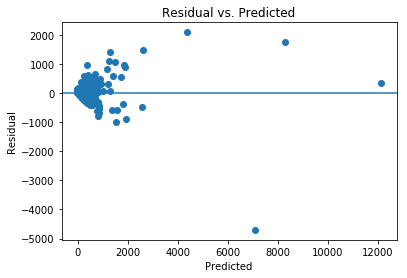

In [28]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y = 0)
plt.title('Residual vs. Predicted')
plt.show()

Some of the model assumptions are violated a little bit - namely the residuals are not really normally distributed and there is some heteroscedasticity in the model.

#### Use PCA for feature selection
There are a number of variables in this data set, so using PCA to decide which features are important.
From this reference:
https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components

In [2]:
#data.head(2)

In [3]:
#from sklearn.decomposition import PCA
#np.random.seed(0)

In [5]:
# 10 samples with 5 features
#train_features = np.random.rand(10,15)

#model = PCA(n_components=10).fit(train_features)
#X_pc = model.transform(train_features)

# number of components
#n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
#most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

#initial_feature_names = ['col_1','col_2','col_3','col_4','col_5', 'col_6', 'col_7', 'col_8', 'col_9', 'col_10',
#                         'col_11', 'col_12', 'col_13', 'col_14', 'col_15']
# get the names
#most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
#dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
#df = pd.DataFrame(dic.items())

In [6]:
#print(df)